*WACV 2022 Submission #1151*

*Learning Invariant Representations Using Polar Harmonic Transforms Equivariant Networks*

Paper ID 1151

Aug 20, 2021

This Demo is tested in Google Colab:
- Browser Google Chrome Version 92.0.4515.107 (Official Build) (64-bit)

In [1]:
pip install tensorflow==1.15

     |████████████████████████████████| 412.3 MB 26 kB/s 
     |████████████████████████████████| 3.8 MB 69.9 MB/s 
     |████████████████████████████████| 50 kB 7.2 MB/s 
     |████████████████████████████████| 503 kB 76.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=6192b9022804622b5d5e220b2193089d5fc29f210fa7fca6b5b7b76fc1c647eb
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [2]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/SE2CNN-master/')

Mounted at /content/drive


In [3]:
# Impor tensorflow and numpy
import tensorflow as tf
import numpy as np
import math as m
import time
# For validation
from sklearn.metrics import confusion_matrix
import itertools

# For plotting
from matplotlib import pyplot as plt

# Import the library
import se2cnn.layers

In [4]:
from ORIT_PCET import PCET

In [5]:
help(se2cnn.layers.z2_se2n)
help(se2cnn.layers.se2n_se2n)
help(se2cnn.layers.spatial_max_pool)

Help on function z2_se2n in module se2cnn.layers:

z2_se2n(input_tensor, kernel, orientations_nb, periodicity=6.283185307179586, diskMask=True, padding='VALID')
    Constructs a group convolutional layer.
    (lifting layer from Z2 to SE2N with N input number of orientations)
    
    INPUT:
        - input_tensor in Z2, a tensorflow Tensor with expected shape:
            [BatchSize, Height, Width, ChannelsIN]
        - kernel, a tensorflow Tensor with expected shape:
            [kernelSize, kernelSize, ChannelsIN, ChannelsOUT]
        - orientations_nb, an integer specifying the number of rotations
    
    INPUT (optional):
        - periodicity, rotate in total over 2*np.pi or np.pi
        - disk_mask, True or False, specifying whether or not to mask the kernels spatially
    
    OUTPUT:
        - output_tensor, the tensor after group convolutions with shape
            [BatchSize, Height', Width', orientations_nb, ChannelsOut]
            (Height', Width' are reduced sizes due 

In [6]:
# Xavier's/He-Rang-Zhen-Sun initialization for layers that are followed ReLU
def weight_initializer(n_in, n_out):
    return tf.random_normal_initializer(mean=0.0, stddev=m.sqrt(2.0 / (n_in))
    )

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def size_of(tensor) :
    # Multiply elements one by one
    result = 1
    for x in tensor.get_shape().as_list():
         result = result * x 
    return result

In [9]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
valid_data = mnist.validation.images # Returns np.array
valid_labels = np.asarray(mnist.validation.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-u

In [10]:
print(valid_data.shape)

(5000, 784)


<class 'numpy.ndarray'>


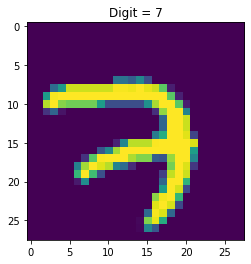

In [11]:
# Reshape to 2D multi-channel images
train_data_2D = train_data.reshape([len(train_data),28,28,1]) # [batch_size, Nx, Ny, Nc]
eval_data_2D = eval_data.reshape([len(eval_data),28,28,1])
print(type(train_labels))
# Plot the first sample
plt.plot()
plt.title('Digit = %d' % train_labels[0])
plt.imshow(train_data_2D[0,:,:,0])

In [12]:
train_data_2D = np.pad(train_data_2D,((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=((0,0),(0,0),(0,0),(0,0)))
eval_data_2D = np.pad(eval_data_2D,((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=((0,0),(0,0),(0,0),(0,0)))

In [13]:
graph = tf.Graph()
graph.as_default()
tf.reset_default_graph()

In [14]:
Ntheta = 12 # Kernel size in angular direction
Nxy=5       # Kernel size in spatial direction
Nc = 4      # Number of channels in the initial layer

In [15]:
inputs_ph = tf.placeholder( dtype = tf.float32, shape = [None,32,32,1] )
labels_ph = tf.placeholder( dtype = tf.int32, shape = [None,] )

In [16]:
print(inputs_ph.shape)
tensor_in = inputs_ph
Nc_in = 1

(?, 32, 32, 1)


In [17]:
kernels={}

In [18]:
with tf.variable_scope("Layer_{}".format(1)) as _scope:
    ## Settings
    Nc_out = Nc

    ## Perform lifting convolution
    # The kernels used in the lifting layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # Lifting layer
    tensor_out, kernels_formatted = se2cnn.layers.z2_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw,
                            orientations_nb = Ntheta)
    # Add bias
    tensor_out = tensor_out + bias
    
    ## Perform (spatial) max-pooling
    tensor_out = se2cnn.layers.spatial_max_pool( input_tensor=tensor_out, nbOrientations=Ntheta)
    
    ## Apply ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

Z2-SE2N BASE KERNEL SHAPE: (5, 5, 1, 4)

Z2-SE2N ROTATED KERNEL SET SHAPE: (12, 5, 5, 1, 4)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 28, 28, 12, 4)



In [19]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(12), Dimension(4)])

In [20]:
with tf.variable_scope("Layer_{}".format(2)) as _scope:
    ## Settings
    Nc_out = 2*Nc

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Ntheta,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Ntheta*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # The group convolution layer
    tensor_out, kernels_formatted = se2cnn.layers.se2n_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw)
    tensor_out = tensor_out + bias
    
    ## Perform max-pooling
    tensor_out = se2cnn.layers.spatial_max_pool( input_tensor=tensor_out, nbOrientations=Ntheta)
    
    ## Apply ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

SE2N-SE2N BASE KERNEL SHAPE: (5, 5, 12, 4, 8)
SE2N-SE2N ROTATED KERNEL SET SHAPE: (12, 5, 5, 12, 4, 8)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 10, 10, 12, 8)


In [21]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(5), Dimension(5), Dimension(12), Dimension(8)])

In [22]:
# Concatenate the orientation and channel dimension
tensor_in = tf.concat([tensor_in[:,:,:,i,:] for i in range(Ntheta)],3)
Nc_in = tensor_in.get_shape().as_list()[-1]

# 2D convolution layer
with tf.variable_scope("Layer_{}".format(3)) as _scope:
    ## Settings
    Nc_out = 128

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # Convolution layer
    tensor_out = tf.nn.conv2d(
                        input = tensor_in,
                        filter=kernels_raw,
                        strides=[1, 1, 1, 1],
                        padding="SAME")
    tensor_out = tensor_out + bias
    
    ## Apply ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_raw

In [23]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(5), Dimension(5), Dimension(128)])

In [24]:
    kernels[_scope.name] = kernels_raw


In [25]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(5), Dimension(5), Dimension(128)])

In [26]:
# 2D convolution layer
with tf.variable_scope("Layer_{}".format(4)) as _scope:
    ## Settings
    Nc_out = 128
    Nc_in = 21*128
    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nc_in,Nc_out],
                        initializer=weight_initializer(Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    tensor_out = PCET(tensor_in)
    tensor_out = tf.add(tf.matmul(tensor_out, kernels_raw), bias)
    tensor_out = tf.nn.relu(tensor_out)
    
    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_raw

In [27]:
with tf.variable_scope("Layer_{}".format(5)) as _scope:
    ## Settings
    Nc_out = 10

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nc_in,Nc_out],
                        initializer=weight_initializer(Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))

    # finally we multiply the fully connected layer with the weights and add a bias term. 
    tensor_out = tf.add(tf.matmul(tensor_in, kernels_raw), bias) 
        
    ## The output logits
    logits = tensor_out
    predictions = tf.argmax(input=logits, axis=1)
    probabilities = tf.nn.softmax(logits)
    
    ## Save the kernels for later inspection
    kernels[_scope.name] = kernels_raw

In [28]:
logits.get_shape()

TensorShape([Dimension(None), Dimension(10)])

In [29]:
# Cross-entropy loss
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels_ph, logits=logits)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [30]:
#-- Define the l2 loss 
weightDecay=5e-4
# Get the raw kernels
variables_wd = tf.get_collection('raw_kernels')
print('-----')
print('RAW kernel shapes:')
for v in variables_wd: print( "[{}]: {}, total nr of weights = {}".format(v.name, v.get_shape(), size_of(v)))
print('-----')
loss_l2 = weightDecay*sum([tf.nn.l2_loss(ker) for ker in variables_wd])

-----
RAW kernel shapes:
[Layer_1/kernel:0]: (5, 5, 1, 4), total nr of weights = 100
[Layer_2/kernel:0]: (5, 5, 12, 4, 8), total nr of weights = 9600
[Layer_3/kernel:0]: (5, 5, 96, 128), total nr of weights = 307200
[Layer_4/kernel:0]: (2688, 128), total nr of weights = 344064
[Layer_5/kernel:0]: (128, 10), total nr of weights = 1280
-----


In [31]:
# Configure the Training Op (for TRAIN mode)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

train_op = optimizer.minimize(
    loss=loss + loss_l2,
    global_step=tf.train.get_global_step())

In [32]:
#-- Start the (GPU) session
initializer = tf.global_variables_initializer()
session = tf.Session(graph=tf.get_default_graph()) #-- Session created
session.run(initializer)

In [33]:
batch_size=100
n_epochs=10

In [34]:
for epoch_nr in range(n_epochs):
    loss_average = 0
    data = train_data_2D
    labels = train_labels
    # KBatch settings
    NItPerEpoch = m.floor(len(data)/batch_size) #number of iterations per epoch
    samples=np.random.permutation(len(data))
    # Loop over dataset
    tStart = time.time()
    for iteration in range(NItPerEpoch):
        feed_dict = {
                inputs_ph: np.array(data[samples[iteration*batch_size:(iteration+1)*batch_size]]),
                labels_ph: np.array(labels[samples[iteration*batch_size:(iteration+1)*batch_size]])
                }
        operators_output = session.run([ loss , train_op ], feed_dict)
        loss_average += operators_output[0]/NItPerEpoch
    tElapsed = time.time() - tStart
    print('Epoch ' , epoch_nr , ' finished... Average loss = ' , round(loss_average,4) , ', time = ',round(tElapsed,4))

Epoch  0  finished... Average loss =  0.1971 , time =  16.4375
Epoch  1  finished... Average loss =  0.0513 , time =  9.1949
Epoch  2  finished... Average loss =  0.0378 , time =  9.1609
Epoch  3  finished... Average loss =  0.0328 , time =  9.1557
Epoch  4  finished... Average loss =  0.031 , time =  9.1686
Epoch  5  finished... Average loss =  0.0284 , time =  9.1934
Epoch  6  finished... Average loss =  0.0265 , time =  9.2115
Epoch  7  finished... Average loss =  0.0245 , time =  9.2089
Epoch  8  finished... Average loss =  0.0245 , time =  9.3079
Epoch  9  finished... Average loss =  0.0214 , time =  9.2962


In [35]:
batch_size = 1000
labels_pred = []
for i in range(round(len(eval_data_2D)/batch_size)):
    [ labels_pred_batch ] = session.run([ predictions ], { inputs_ph: eval_data_2D[i*batch_size:(i+1)*batch_size] })
    labels_pred = labels_pred + list(labels_pred_batch)
labels_pred = np.array(labels_pred)

In [36]:
print(labels_pred[0:10])
print(eval_labels[0:10])

[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


In [37]:
((labels_pred - eval_labels)**2==0).astype(float).mean()

0.9887

In [38]:
((labels_pred - eval_labels)**2>0).astype(float).sum()

113.0

In [39]:
100*((labels_pred - eval_labels)**2>0).astype(float).mean()

1.13

Confusion matrix, without normalization


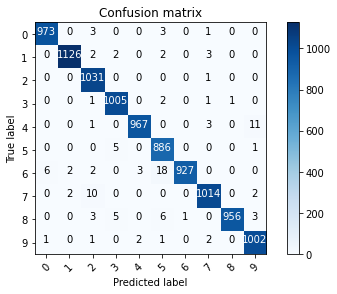

In [40]:
cm = confusion_matrix(eval_labels, labels_pred)
plot_confusion_matrix(cm, range(10))